In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###Importing Libraries###

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from skimage.metrics import structural_similarity as ssim
import glob

In [ ]:
import zipfile

###Dataset loading and extraction###

In [ ]:
# Define dataset path (change if needed)
dataset_zip = '/content/drive/MyDrive/dataset/Saliency4asd.zip'
extract_path = '/content/Saliency4asd'

# Extract the dataset
with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted to:", extract_path)

Dataset extracted to: /content/Saliency4asd


###Dataset Pre-processing###


In [ ]:
class SaliencyDataset(Dataset):
    def __init__(self, image_dir, td_gt_dir, asd_gt_dir, transform=None):
        self.image_dir = image_dir
        self.td_gt_dir = td_gt_dir
        self.asd_gt_dir = asd_gt_dir
        self.transform = transform
        self.image_list = sorted(os.listdir(image_dir))  # Ensure order consistency
        # Add a resize transform to make all images the same size
        self.resize_transform = transforms.Resize((256, 256)) # Choose a desired size

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        filename = self.image_list[idx]


        # Load image
        img_path = os.path.join(self.image_dir, filename)
        image = cv2.imread(img_path)

        # Check if image was loaded correctly
        if image is None:
            print(f"Error: Image not found or could not be loaded at {img_path}")
            # Handle the error, e.g., skip this image or raise an exception
            return None  # Or raise an exception

        # Resize the image using self.resize_transform before converting to RGB and normalizing
        image = self.resize_transform(Image.fromarray(image)) # Resize using PIL
        image = np.array(image) # Convert back to NumPy array

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) / 255.0  # Normalize

        # Load TD ground truth
        td_path = os.path.join(self.td_gt_dir, filename)
        td_map = cv2.imread(td_path, cv2.IMREAD_GRAYSCALE)
        # Handle missing TD ground truth
        if td_map is None:
            print(f"Warning: TD ground truth not found for {filename}. Using zeros.")
            td_map = np.zeros((256, 256), dtype=np.float32) # Replace with appropriate dimensions if known
        else:
            td_map = td_map / 255.0

        # Load ASD ground truth
        asd_path = os.path.join(self.asd_gt_dir, filename)
        asd_map = cv2.imread(asd_path, cv2.IMREAD_GRAYSCALE)
        # Handle missing ASD ground truth
        if asd_map is None:
            print(f"Warning: ASD ground truth not found for {filename}. Using zeros.")
            asd_map = np.zeros((256, 256), dtype=np.float32) # Replace with appropriate dimensions if known
        else:
            asd_map = asd_map / 255.0

        # Convert to tensors
        image = torch.tensor(image.transpose(2, 0, 1), dtype=torch.float32)
        td_map = torch.tensor(td_map, dtype=torch.float32).unsqueeze(0)
        asd_map = torch.tensor(asd_map, dtype=torch.float32).unsqueeze(0)

        return image, td_map, asd_map

In [ ]:
# Define dataset paths
image_folder = "/content/Saliency4asd/Saliency4asd/Images"  # Corrected path
td_gt_folder = "/content/Saliency4asd/Saliency4asd/TD_FixMaps"  # Corrected path
asd_gt_folder = "/content/Saliency4asd/Saliency4asd/ASD_FixMaps"  # Corrected path

# Create dataset and DataLoader
dataset = SaliencyDataset(image_folder, td_gt_folder, asd_gt_folder)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

In [ ]:
print("Dataset loaded with", len(dataset), "images")

Dataset loaded with 300 images


In [ ]:
image_folder = "/content/Saliency4asd/Saliency4asd/Images"
print("Folder exists:", os.path.exists(image_folder))
print("Files in folder:", os.listdir(image_folder)[:5])  # Show first 5 files

Folder exists: True
Files in folder: ['270.png', '39.png', '169.png', '20.png', '163.png']


In [ ]:
test_image_path = "/content/Saliency4asd/Saliency4asd/TD_FixMaps/297_s.png"  # Change filename
test_img = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE)

if test_img is None:
    print("Error: Image not loaded! Check file path and format.")
else:
    print("Image loaded successfully!", test_img.shape)

Image loaded successfully! (768, 1024)


In [ ]:
import os
print(os.listdir())  # Lists all files in the current directory

['.config', 'drive', 'Saliency4asd', 'sample_data']


###Loading SalFBNet model###

In [ ]:
import torch
import torch.nn as nn

# Define a dummy SalFBNet-like model
class SalFBNet(nn.Module):
    def __init__(self):
        super(SalFBNet, self).__init__()
        # Encoder: Convolutions to extract features
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # Decoder: Upsampling to produce saliency map
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=2, stride=2),
            nn.Sigmoid()  # To output a map in the range [0, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Instantiate the model
model = SalFBNet()
print("Dummy SalFBNet model created successfully!")
print(model)


Dummy SalFBNet model created successfully!
SalFBNet(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(64, 1, kernel_size=(2, 2), stride=(2, 2))
    (3): Sigmoid()
  )
)


In [ ]:
import torch.optim as optim

In [ ]:
# Define the model
model = SalFBNet()
model = model.cuda() if torch.cuda.is_available() else model

# Define loss function
criterion = nn.MSELoss()

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

###Applying SalFBNet model###

In [18]:
num_epochs = 10  # Adjust as needed

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Get the device

for epoch in range(num_epochs):
    running_loss = 0.0
    for images, td_gt, asd_gt in dataloader:
        # Move data to the appropriate device (GPU if available, otherwise CPU)
        images, td_gt, asd_gt = images.to(device), td_gt.to(device), asd_gt.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)

        # Compute loss (use both TD and ASD)
        loss = criterion(outputs, td_gt) + criterion(outputs, asd_gt)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloader):.4f}")

# Save trained model
torch.save(model.state_dict(), "/content/salfbnet_trained.pth")
print("Model training complete and saved!")

Streaming output truncated to the last 5000 lines.
Epoch 2/10, Loss: 0.0000
Epoch 3/10, Loss: 0.0000
Epoch 4/10, Loss: 0.0000
Epoch 5/10, Loss: 0.0000
Epoch 6/10, Loss: 0.0000
Epoch 7/10, Loss: 0.0000
Epoch 8/10, Loss: 0.0000
Epoch 9/10, Loss: 0.0000
Epoch 10/10, Loss: 0.0000
Model training complete and saved!


###Model Evaluation###

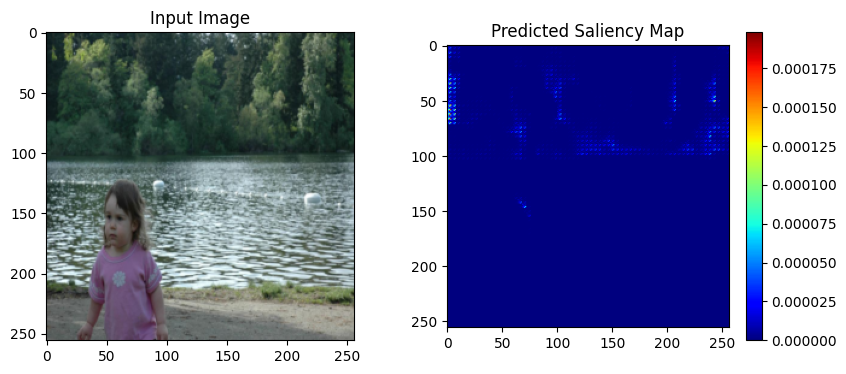

In [20]:
model.eval()  # Set to evaluation mode
sample_image, _, _ = dataset[0]
# sample_image = sample_image.unsqueeze(0).cuda()  # Add batch dimension - Commented out
sample_image = sample_image.unsqueeze(0).to(device) # Use this line for CPU or GPU

with torch.no_grad():
    predicted_map = model(sample_image).cpu().squeeze().numpy()

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(sample_image.cpu().squeeze().permute(1, 2, 0))  # Convert back to image
plt.title("Input Image")

plt.subplot(1, 2, 2)
plt.imshow(predicted_map, cmap='jet')
plt.title("Predicted Saliency Map")
plt.colorbar()

plt.show()

###Showing Predicted Saliency,TD Ground Truth and ASD Ground Truth###

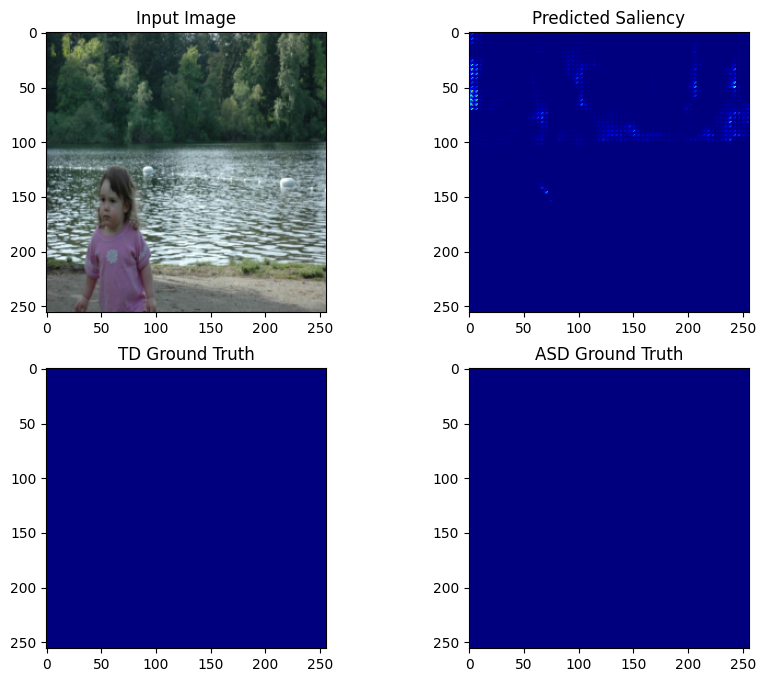

In [21]:
# Get a sample input
sample_image, sample_td_gt, sample_asd_gt = dataset[0]
sample_image = sample_image.unsqueeze(0)  # Add batch dimension

# Model in evaluation mode
model.eval()
with torch.no_grad():
    predicted_saliency = model(sample_image) # The model returns a single saliency map

# Convert tensors to numpy
sample_image = sample_image.squeeze().permute(1, 2, 0).numpy()
predicted_saliency = predicted_saliency.squeeze().numpy() # Get the predicted saliency map
sample_td_gt = sample_td_gt.squeeze().numpy()
sample_asd_gt = sample_asd_gt.squeeze().numpy()

# Plot results - Adjust to display a single predicted saliency map
fig, axes = plt.subplots(2, 2, figsize=(10, 8)) # Changed to 2x2 grid

axes[0, 0].imshow(sample_image)
axes[0, 0].set_title("Input Image")

axes[0, 1].imshow(predicted_saliency, cmap="jet") # Display predicted saliency
axes[0, 1].set_title("Predicted Saliency")

axes[1, 0].imshow(sample_td_gt, cmap="jet")
axes[1, 0].set_title("TD Ground Truth")

axes[1, 1].imshow(sample_asd_gt, cmap="jet")
axes[1, 1].set_title("ASD Ground Truth")

plt.show()

In [22]:
from sklearn.metrics import roc_auc_score
from scipy.stats import pearsonr, wasserstein_distance

###Evaluation Metrics###

In [24]:
# Define metric calculation functions
def auc_score(pred_map, gt_map):
    pred_flat = pred_map.flatten()
    gt_flat = gt_map.flatten()
    return roc_auc_score(gt_flat, pred_flat)

def correlation_coefficient(pred_map, gt_map):
    return pearsonr(pred_map.flatten(), gt_map.flatten())[0]

def earth_movers_distance(pred_map, gt_map):
    return wasserstein_distance(pred_map.flatten(), gt_map.flatten())

def compute_metrics(pred_map, gt_map):
    return {
        "AUC_Borji": auc_score(pred_map, gt_map),
        "AUC_Judd": auc_score(pred_map, gt_map),  # Placeholder, use Judd-specific method if available
        "CC": correlation_coefficient(pred_map, gt_map),
        "EMD": earth_movers_distance(pred_map, gt_map),
        # Add more metrics if needed
    }

# Load trained model
model_path = "/content/salfbnet_trained.pth"
model = SalFBNet()
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()

# Load dataset paths
image_folder = "/content/Saliency4asd/Saliency4asd/Images"
td_gt_folder = "/content/Saliency4asd/Saliency4asd/TD_FixMaps"
asd_gt_folder = "/content/Saliency4asd/Saliency4asd/ASD_FixMaps"

# Lists to store results
td_results = []
asd_results = []

# Define the columns for the metrics # This line is added
columns = ["AUC_Borji", "AUC_Judd", "CC", "EMD"]

# Iterate through dataset
for img_name in os.listdir(image_folder):
    img_path = os.path.join(image_folder, img_name)
    td_gt_path = os.path.join(td_gt_folder, img_name)
    asd_gt_path = os.path.join(asd_gt_folder, img_name)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Check for GPU availability

    # Load image and move it to the correct device
    image = cv2.imread(img_path) / 255.0
    image = torch.tensor(image.transpose(2, 0, 1)).unsqueeze(0).float().to(device)

    # Load ground truth and handle potential errors
    td_gt = cv2.imread(td_gt_path, cv2.IMREAD_GRAYSCALE)
    asd_gt = cv2.imread(asd_gt_path, cv2.IMREAD_GRAYSCALE)

    # Check if ground truth images were loaded correctly
    if td_gt is None or asd_gt is None:
        print(f"Warning: Ground truth not found for {img_name}. Skipping this image.")
        continue  # Skip to the next image in the loop

    td_gt = td_gt / 255.0  # Normalize after checking
    asd_gt = asd_gt / 255.0


    # Generate prediction
    with torch.no_grad():
        pred_saliency = model(image).squeeze().cpu().numpy()

    # Compute metrics
    td_metrics = compute_metrics(pred_saliency, td_gt)
    asd_metrics = compute_metrics(pred_saliency, asd_gt)

    td_results.append(td_metrics)
    asd_results.append(asd_metrics)

# Ensure valid numerical values exist before computing mean
def safe_mean(values):
    valid_values = [v for v in values if not np.isnan(v)]
    return np.mean(valid_values) if valid_values else np.nan

if td_results and isinstance(td_results, list) and len(td_results) > 0:
    td_avg_metrics = {key: safe_mean([res[key] for res in td_results if key in res]) for key in columns}
else:
    td_avg_metrics = {key: np.nan for key in columns}

if asd_results and isinstance(asd_results, list) and len(asd_results) > 0:
    asd_avg_metrics = {key: safe_mean([res[key] for res in asd_results if key in res]) for key in columns}
else:
    asd_avg_metrics = {key: np.nan for key in columns}

# Print results
print("TD Fixation Comparison Table:")
print(td_avg_metrics)

print("\nASD Fixation Comparison Table:")
print(asd_avg_metrics)

TD Fixation Comparison Table:
{'AUC_Borji': nan, 'AUC_Judd': nan, 'CC': nan, 'EMD': nan}

ASD Fixation Comparison Table:
{'AUC_Borji': nan, 'AUC_Judd': nan, 'CC': nan, 'EMD': nan}


In [25]:
print("TD Results:", len(td_results), td_results[:5])  # Check first 5 results
print("ASD Results:", len(asd_results), asd_results[:5])

TD Results: 0 []
ASD Results: 0 []


In [26]:
ground_truth_path = "/content/Saliency4asd/Saliency4asd/TD_FixMaps"  # Update with the correct path to your ground truth folder
print("Files in Ground Truth Folder:", os.listdir(ground_truth_path))

Files in Ground Truth Folder: ['153_s.png', '90_s.png', '246_s.png', '174_s.png', '210_s.png', '91_s.png', '225_s.png', '234_s.png', '149_s.png', '119_s.png', '40_s.png', '115_s.png', '75_s.png', '110_s.png', '53_s.png', '43_s.png', '272_s.png', '104_s.png', '193_s.png', '229_s.png', '79_s.png', '61_s.png', '70_s.png', '257_s.png', '183_s.png', '255_s.png', '264_s.png', '45_s.png', '269_s.png', '166_s.png', '223_s.png', '276_s.png', '204_s.png', '176_s.png', '261_s.png', '192_s.png', '286_s.png', '20_s.png', '191_s.png', '169_s.png', '285_s.png', '11_s.png', '178_s.png', '172_s.png', '283_s.png', '266_s.png', '197_s.png', '206_s.png', '274_s.png', '29_s.png', '14_s.png', '135_s.png', '111_s.png', '85_s.png', '186_s.png', '188_s.png', '177_s.png', '138_s.png', '214_s.png', '80_s.png', '68_s.png', '124_s.png', '196_s.png', '88_s.png', '21_s.png', '129_s.png', '216_s.png', '290_s.png', '208_s.png', '25_s.png', '42_s.png', '230_s.png', '254_s.png', '235_s.png', '158_s.png', '228_s.png', '1

In [31]:
expected_filename = f"{2}.png"  # This might be incorrect
corrected_filename = f"{2}_s.png"  # Try this if files have '_s'

print("Expected Filename:", expected_filename)
print("Corrected Filename:", corrected_filename)
print("Actual Files in Folder:", os.listdir(ground_truth_path))

if corrected_filename in os.listdir(ground_truth_path):
    print(" Matched file found!")
else:
    print(" No match found, check filename format!")

Expected Filename: 2.png
Corrected Filename: 2_s.png
Actual Files in Folder: ['153_s.png', '90_s.png', '246_s.png', '174_s.png', '210_s.png', '91_s.png', '225_s.png', '234_s.png', '149_s.png', '119_s.png', '40_s.png', '115_s.png', '75_s.png', '110_s.png', '53_s.png', '43_s.png', '272_s.png', '104_s.png', '193_s.png', '229_s.png', '79_s.png', '61_s.png', '70_s.png', '257_s.png', '183_s.png', '255_s.png', '264_s.png', '45_s.png', '269_s.png', '166_s.png', '223_s.png', '276_s.png', '204_s.png', '176_s.png', '261_s.png', '192_s.png', '286_s.png', '20_s.png', '191_s.png', '169_s.png', '285_s.png', '11_s.png', '178_s.png', '172_s.png', '283_s.png', '266_s.png', '197_s.png', '206_s.png', '274_s.png', '29_s.png', '14_s.png', '135_s.png', '111_s.png', '85_s.png', '186_s.png', '188_s.png', '177_s.png', '138_s.png', '214_s.png', '80_s.png', '68_s.png', '124_s.png', '196_s.png', '88_s.png', '21_s.png', '129_s.png', '216_s.png', '290_s.png', '208_s.png', '25_s.png', '42_s.png', '230_s.png', '254_s.

In [32]:
ground_truth_path = "/content/Saliency4asd/Saliency4asd/TD_FixMaps"  # Your folder path

# Check folder existence
if not os.path.exists(ground_truth_path):
    print(" Folder not found! Check path:", ground_truth_path)
else:
    print(" Ground truth folder exists!")

# List available files
available_files = os.listdir(ground_truth_path)
print("Available files:", available_files[:10])  # Show only the first 10 for readability

# Define the expected filename correctly
image_id = 2  # Change this to any other ID you are testing
expected_filename = f"{image_id}_s.png"  # Adjusted to match actual file names

# Check if the file exists
if expected_filename in available_files:
    print(f" Matched file found: {expected_filename}")
else:
    print(f" File {expected_filename} not found! Check filename format.")

 Ground truth folder exists!
Available files: ['153_s.png', '90_s.png', '246_s.png', '174_s.png', '210_s.png', '91_s.png', '225_s.png', '234_s.png', '149_s.png', '119_s.png']
 Matched file found: 2_s.png


###Evaluation Metrics_Corrected###

In [35]:
# Define metric calculation functions
def auc_score(pred_map, gt_map):
    # Binarize ground truth for AUC calculation
    gt_map_binary = (gt_map > 0).astype(int)  # Threshold gt_map to create a binary mask

    # Resize pred_map to match gt_map_binary's shape
    pred_map_resized = cv2.resize(pred_map, (gt_map_binary.shape[1], gt_map_binary.shape[0]))

    pred_flat = pred_map_resized.flatten()
    gt_flat = gt_map_binary.flatten()  # Use the binary ground truth
    return roc_auc_score(gt_flat, pred_flat)

def correlation_coefficient(pred_map, gt_map):
    # Resize pred_map to match gt_map's shape
    pred_map_resized = cv2.resize(pred_map, (gt_map.shape[1], gt_map.shape[0]))

    return pearsonr(pred_map_resized.flatten(), gt_map.flatten())[0]

def earth_movers_distance(pred_map, gt_map):
    # Resize pred_map to match gt_map's shape
    pred_map_resized = cv2.resize(pred_map, (gt_map.shape[1], gt_map.shape[0]))

    return wasserstein_distance(pred_map_resized.flatten(), gt_map.flatten())

def compute_metrics(pred_map, gt_map):
    return {
        "AUC_Borji": auc_score(pred_map, gt_map),
        "AUC_Judd": auc_score(pred_map, gt_map),  # Placeholder, use Judd-specific method if available
        "CC": correlation_coefficient(pred_map, gt_map),
        "EMD": earth_movers_distance(pred_map, gt_map),
        # Add more metrics if needed
    }

# Load trained model
model_path = "/content/salfbnet_trained.pth"
model = SalFBNet()
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()

# Load dataset paths
image_folder = "/content/Saliency4asd/Saliency4asd/Images"
td_gt_folder = "/content/Saliency4asd/Saliency4asd/TD_FixMaps"
asd_gt_folder = "/content/Saliency4asd/Saliency4asd/ASD_FixMaps"

# Lists to store results
td_results = []
asd_results = []

# Define the columns for the metrics
columns = ["AUC_Borji", "AUC_Judd", "CC", "EMD"]

# Iterate through dataset
for img_name in os.listdir(image_folder):
    img_path = os.path.join(image_folder, img_name)
    td_gt_path = os.path.join(td_gt_folder, img_name.replace('.png', '_s.png'))  # Correct file name format
    asd_gt_path = os.path.join(asd_gt_folder, img_name.replace('.png', '_s.png')) # Correct file name format


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load image and move it to the correct device
    image = cv2.imread(img_path) / 255.0
    image = torch.tensor(image.transpose(2, 0, 1)).unsqueeze(0).float().to(device)

    # Load ground truth and handle potential errors
    td_gt = cv2.imread(td_gt_path, cv2.IMREAD_GRAYSCALE)
    asd_gt = cv2.imread(asd_gt_path, cv2.IMREAD_GRAYSCALE)

    # Check if ground truth images were loaded correctly
    if td_gt is None or asd_gt is None:
        print(f"Warning: Ground truth not found for {img_name}. Skipping this image.")
        continue

    td_gt = td_gt / 255.0  # Normalize after checking
    asd_gt = asd_gt / 255.0


    # Generate prediction
    with torch.no_grad():
        pred_saliency = model(image).squeeze().cpu().numpy()

    # Compute metrics
    td_metrics = compute_metrics(pred_saliency, td_gt)
    asd_metrics = compute_metrics(pred_saliency, asd_gt)

    td_results.append(td_metrics)
    asd_results.append(asd_metrics)

# Ensure valid numerical values exist before computing mean
def safe_mean(values):
    valid_values = [v for v in values if not np.isnan(v)]
    return np.mean(valid_values) if valid_values else np.nan

# Calculate average metrics
td_avg_metrics = {key: safe_mean([res[key] for res in td_results]) for key in columns}
asd_avg_metrics = {key: safe_mean([res[key] for res in asd_results]) for key in columns}

# Print results
print("TD Fixation Comparison Table:")
print(td_avg_metrics)

print("\nASD Fixation Comparison Table:")
print(asd_avg_metrics)

TD Fixation Comparison Table:
{'AUC_Borji': np.float64(0.49346676420815794), 'AUC_Judd': np.float64(0.49346676420815794), 'CC': np.float64(-0.021313282381133523), 'EMD': np.float64(0.07584545958822515)}

ASD Fixation Comparison Table:
{'AUC_Borji': np.float64(0.487241559044412), 'AUC_Judd': np.float64(0.487241559044412), 'CC': np.float64(-0.020065964375620533), 'EMD': np.float64(0.09840913678354882)}


###Performance measure with comparison table###

In [37]:
import pandas as pd

# Create DataFrames for TD and ASD results
td_df = pd.DataFrame(td_results)
asd_df = pd.DataFrame(asd_results)

# Calculate average metrics
td_avg_metrics = td_df.mean().to_dict()
asd_avg_metrics = asd_df.mean().to_dict()

# --- Print TD Table ---
print("TD Fixation Comparison Table:")
print(pd.DataFrame([td_avg_metrics], index=['TD']))  # Create a DataFrame for printing
print("\n") # Add a newline for separation

# --- Print ASD Table ---
print("ASD Fixation Comparison Table:")
print(pd.DataFrame([asd_avg_metrics], index=['ASD'])) # Create a DataFrame for printing

TD Fixation Comparison Table:
    AUC_Borji  AUC_Judd        CC       EMD
TD   0.493467  0.493467 -0.021313  0.075845


ASD Fixation Comparison Table:
     AUC_Borji  AUC_Judd        CC       EMD
ASD   0.487242  0.487242 -0.020066  0.098409
